In [3]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set(font_scale=2)

In [4]:
pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

In [5]:
### https://saturncloud.io/blog/how-to-change-the-path-in-google-colab/
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/dataset')

pwd = '/content/drive/My Drive/Colab Notebooks/dataset'

Mounted at /content/drive


In [6]:
def data_processing(data , half_chapter ):
    filepath = os.path.join(pwd, data)
    df = pd.read_csv(filepath,  index_col=0)
    df = df.dropna(axis=1, how='all')
    df = df[ df['nchapters'] >= half_chapter ]
    # Delete unrelated columns
    df = df.drop(columns= ['course_id','userid_DI','registered','viewed','explored',
                           'start_time_DI','last_event_DI','incomplete_flag','final_cc_cname_DI'] , axis = 1)
    df = df.dropna( how='any', axis=0)
    df = df[ df['grade']!= " " ]
    df['grade'] = pd.to_numeric(df['grade'])

    if data == "HarvardX_CB22x_2013_Spring.csv" or data == "HarvardX_ER22x_2013_Spring.csv":
      df.loc[:,'nplay_video'] = 0

    y = df.pop('certified')
    #print( y.value_counts() )
    X = pd.get_dummies(df, dtype=float)
    y = y.to_numpy()
    # y = y.reshape(-1,1)
    X = X.to_numpy()
    return X, y

# np.any --> Test whether any array element along a given axis evaluates to True.
# res =  np.any( np.isnan(X), axis = 0)

In [7]:
seed = 34

In [8]:
# None Shift
X, y =  data_processing(data = 'MITx_6.00x_2012_Fall.csv', half_chapter = 9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= seed)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2044, 14)
(228, 14)
(569, 14)


In [9]:
def Normalization(X):
  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)
  return X

In [10]:
# Samll Shift
X_small_shift, y_small_shift =  data_processing(data = 'MITx_6.00x_2013_Spring.csv', half_chapter = 9)
X_large_shift, y_large_shift =  data_processing(data ='HarvardX_CB22x_2013_Spring.csv', half_chapter = 14)
X_large_shift_2, y_large_shift_2 =  data_processing(data ='HarvardX_ER22x_2013_Spring.csv', half_chapter = 17 )

X_small_shift = Normalization(X_small_shift)
X_large_shift = Normalization(X_large_shift)
X_large_shift_2 = Normalization(X_large_shift_2)


In [11]:
# OOD data 1
OOD_1 = pd.read_csv('sonar_X.csv')
OOD_1 = OOD_1.to_numpy()
# y_OOD_1 = pd.read_csv('sonar_y.csv')
# y_OOD_1 = y_OOD_1.to_numpy()

In [12]:
# OOD data 2
OOD_2 = pd.read_csv('ionosphere_X.csv')
OOD_2 = OOD_2.to_numpy()

# OOD_2 = pd.read_csv('ionosphere_y.csv')
# y_OOD_2 = y_OOD_2.to_numpy()

In [14]:

# import logging
# logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
import official.nlp.modeling.layers as nlp_layers
tf.autograph.set_verbosity(0)
tf.random.set_seed(12)
tf.keras.utils.set_random_seed(12)
tf.config.experimental.enable_op_determinism()

In [15]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [16]:
resnet_config = dict(num_classes = 2, num_layers= 3, num_hidden= 64)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build( (None, 14) )
resnet_model.summary()

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  960       
                                                                 
 dense_1 (Dense)             multiple                  4160      
                                                                 
 dense_2 (Dense)             multiple                  4160      
                                                                 
 dense_3 (Dense)             multiple                  4160      
                                                                 
 dense_4 (Dense)             multiple                  130       
                                                                 
Total params: 13570 (53.01 KB)
Trainable params: 12610 (49.26 KB)
Non-trainable params: 960 (3.75 KB)
_________________________________________________________________


In [17]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100,
                                            restore_best_weights = True)

fit_config = dict(batch_size = 32, epochs= 1000,
               validation_data = (X_val, y_val),
               callbacks=[callback] )

In [ ]:
resnet_model.compile(**train_config)
history = resnet_model.fit(X_train, y_train, **fit_config)

<Axes: >

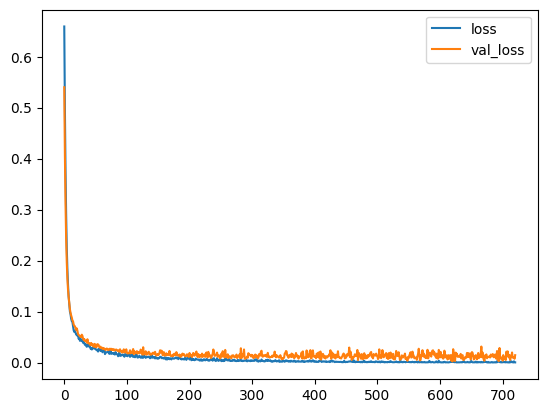

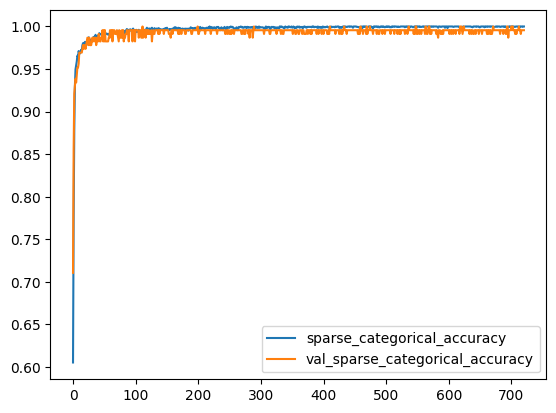

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()
history_df.loc[:, ['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()
# print(("Best Validation Loss: {:0.4f}" +\
#       "\nBest Validation Accuracy: {:0.4f}")\
#       .format(history_df['val_loss'].min(),
#               history_df['val_sparse_categorical_accuracy'].max()))

In [21]:
resnet_logits = resnet_model(X_test)
resnet_probs = tf.nn.softmax(resnet_logits, axis=-1)[:, 0]  # Take the probability for class 0.

In [22]:
probs = np.where( resnet_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_test, probs)
accuracy

0.9894551845342706

In [23]:
resnet_model.evaluate(X_test, y_test)
resnet_model.evaluate(X_small_shift, y_small_shift)
resnet_model.evaluate(X_large_shift, y_large_shift)
resnet_model.evaluate(X_large_shift_2, y_large_shift_2)

18/18 [==============================] - 0s 11ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9895


[0.07266338914632797, 0.9894551634788513]

In [29]:
class DeepResNetSNGP(DeepResNet):
  #
  def __init__( self, spec_norm_bound = 0.9, **kwargs ):
    self.spec_norm_bound = spec_norm_bound

    super().__init__(**kwargs)

  # Override the father class's method
  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier = self.spec_norm_bound)

  # Override the father class's method
  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum = -1,
        **self.classifier_kwargs)
  #
  def call(self, inputs, training=False, return_covmat=False):

    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

In [ ]:
# Implement a Keras callback to reset the covariance matrix at the beginning of a new epoch.

In [30]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [31]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())
    return super().fit(*args, **kwargs)

In [ ]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
history = sngp_model.fit(X_train, y_train, **fit_config)

<Axes: >

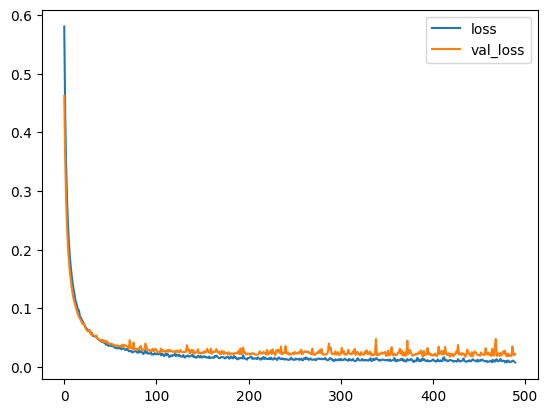

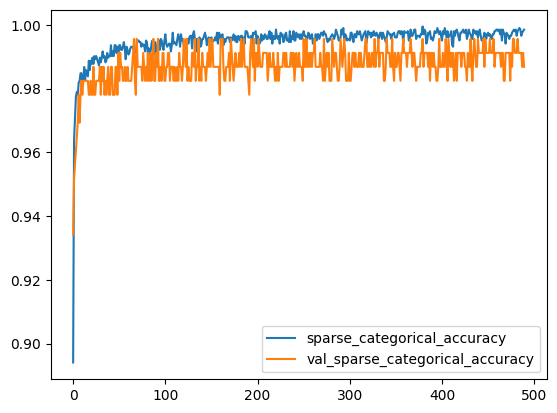

In [33]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()
history_df.loc[:, ['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()

In [34]:
# This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return tf.nn.softmax(logits_adjusted, axis=-1)[:,0]

In [36]:
def compute_results(model, X, y):
  sngp_logits, sngp_covmat = model(X, return_covmat=True)
  sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
  std = np.sqrt(sngp_variance)
  std = np.mean(std)

  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
  probs = np.where( sngp_probs > 0.5 , 0, 1)
  accuracy = accuracy_score(y, probs)

  uncertainty = sngp_probs * (1. - sngp_probs)
  uncertainty = np.mean(uncertainty)

  print(f'accuracy --{accuracy}, std --{std}, uncertainty --{uncertainty}')
  return accuracy, std, uncertainty

compute_results(sngp_model, X_test, y_test)
compute_results(sngp_model, X_small_shift, y_small_shift)
compute_results(sngp_model, X_large_shift, y_large_shift)
compute_results(sngp_model, X_large_shift_2, y_large_shift_2)

accuracy --0.9947275922671354, std --0.20237882435321808, uncertainty --0.007669378537684679
accuracy --0.9931330472103004, std --0.21663233637809753, uncertainty --0.008561803959310055
accuracy --0.9124423963133641, std --0.6325938105583191, uncertainty --0.06699290871620178
accuracy --0.9836122733612274, std --0.5650792121887207, uncertainty --0.03504500910639763


(0.9836122733612274, 0.5650792, 0.03504501)

0.017549526


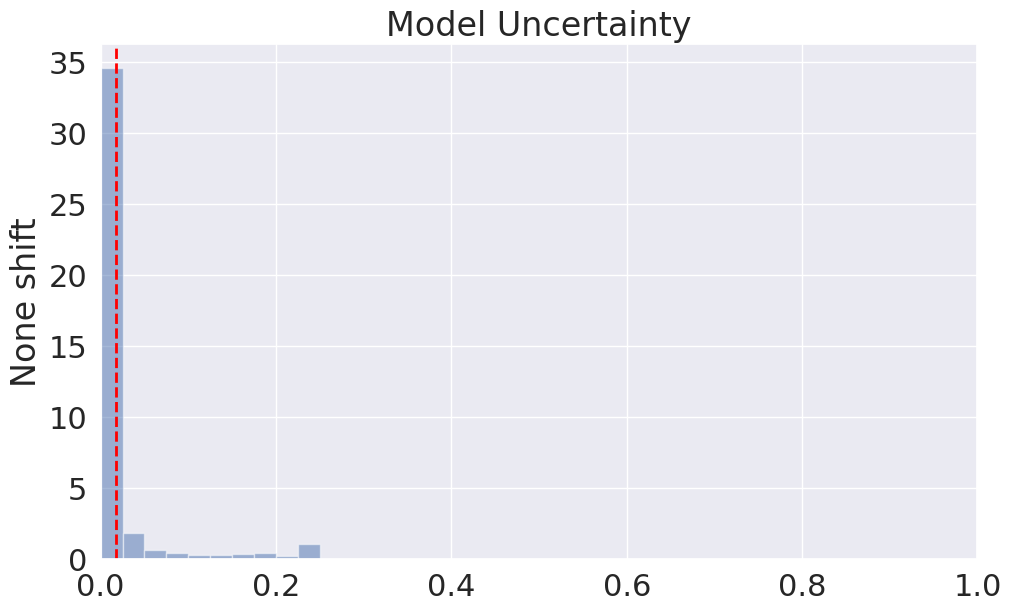

In [ ]:

# def plot_uncertainty(uncertainty, mean_val, ylabel = 'None shift'):
#   fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')
#   # the histogram of the data
#   n, bins, patches = ax.hist(uncertainty, 10, density=True, facecolor='C0', alpha=0.5)
#   ax.axvline(mean_val, c = 'red', ls='--', lw=2,)
#   plt.xlim([0, 1])
#   ax.set_ylabel(ylabel)
#   ax.set_title('Model Uncertainty')
#   ax.grid(True)
#   print(mean_val)
# plot_uncertainty()

In [41]:
def ood_uncertainty(model, ood):
  sngp_logits, sngp_covmat = model(ood, return_covmat=True)
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
  sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
  std = np.sqrt(sngp_variance)
  std = np.mean(std)
  uncertainty = sngp_probs * (1. - sngp_probs)
  uncertainty = np.mean(uncertainty)
  print(f'std--{std}, uncertainty --{uncertainty}')
  return std, uncertainty

ood_uncertainty(sngp_model, OOD_1)
ood_uncertainty(sngp_model, OOD_2)

std--0.7198036909103394, uncertainty --0.0224933885037899
std--0.8429926037788391, uncertainty --0.15416991710662842


(0.8429926, 0.15416992)

In [ ]:
# MC Dropout

In [46]:
num_ensemble = 10

In [47]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

In [48]:
# Monte Carlo dropout inference.

def compute_mcdrop_out_results(model, X, y):
  dropout_logit_samples = [model(X) for _ in range(num_ensemble)]
  dropout_prob_samples = [tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
  dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

  probs = np.where( dropout_probs > 0.5 , 0, 1)
  accuracy = accuracy_score(y, probs)

  uncertainty = (dropout_probs)*(1-dropout_probs)
  uncertainty = np.mean(uncertainty)

  print(f'accuracy: {accuracy} -- Uncertainty:{uncertainty}')
  return accuracy, uncertainty

compute_mcdrop_out_results(mc_dropout_sampling, X_test, y_test )
compute_mcdrop_out_results(mc_dropout_sampling, X_small_shift, y_small_shift )
compute_mcdrop_out_results(mc_dropout_sampling, X_large_shift, y_large_shift )
compute_mcdrop_out_results(mc_dropout_sampling, X_large_shift_2, y_large_shift_2 )

accuracy: 0.9876977152899824 -- Uncertainty:0.0036991292145103216
accuracy: 0.9896995708154507 -- Uncertainty:0.0036663447972387075
accuracy: 0.9423963133640553 -- Uncertainty:0.013972418382763863
accuracy: 0.9755927475592747 -- Uncertainty:0.003859815187752247


(0.9755927475592747, 0.0038598152)

In [51]:
def ood_uncertainty_dropout(model, ood):
  dropout_logit_samples = [mc_dropout_sampling(ood) for _ in range(num_ensemble)]
  dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
  dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)
  uncertainty = (dropout_probs)*(1-dropout_probs)
  uncertainty = np.mean(uncertainty)
  print(f'uncertainty -- {uncertainty}')
  return uncertainty

ood_uncertainty_dropout(mc_dropout_sampling, OOD_1)
ood_uncertainty_dropout(mc_dropout_sampling, OOD_2)

uncertainty -- 0.014025602489709854
uncertainty -- 0.0448773130774498


0.044877313

In [ ]:
# Deep ensemble training

In [52]:
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(X_train, y_train, verbose=0, **fit_config)

  resnet_ensemble.append(resnet_model)

In [53]:
def compute_deep_ensemble(model_list, X, y):

  ensemble_logit_samples = [model(X) for model in model_list]
  ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
  ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

  probs = np.where( ensemble_probs > 0.5 , 0, 1)
  accuracy = accuracy_score(y, probs)

  uncertainty = ensemble_probs * (1 - ensemble_probs)
  uncertainty = np.mean(uncertainty)
  print(f'accuracy: {accuracy} -- uncertainty:{uncertainty}')
  return accuracy, uncertainty


compute_deep_ensemble(resnet_ensemble, X_test, y_test)
compute_deep_ensemble(resnet_ensemble, X_small_shift, y_small_shift)
compute_deep_ensemble(resnet_ensemble, X_large_shift, y_large_shift)
compute_deep_ensemble(resnet_ensemble, X_large_shift_2, y_large_shift_2)

accuracy: 0.9912126537785588 -- uncertainty:0.004396406933665276
accuracy: 0.9935622317596566 -- uncertainty:0.004953763913363218
accuracy: 0.9423963133640553 -- uncertainty:0.03544651344418526
accuracy: 0.9773361227336123 -- uncertainty:0.014381799846887589


(0.9773361227336123, 0.0143818)

In [55]:
def ood_uncertainty(model_list, ood):
  ensemble_logit_samples = [model(ood) for model in model_list]
  ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
  ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

  uncertainty = ensemble_probs * (1 - ensemble_probs)
  uncertainty = np.mean(uncertainty)
  print(f'uncertainty -- {uncertainty}')
  return uncertainty

ood_uncertainty(resnet_ensemble, OOD_1)
ood_uncertainty(resnet_ensemble, OOD_2)

uncertainty -- 0.028980037197470665
uncertainty -- 0.10558997094631195


0.10558997